# Dataset description

RAVDESS dataset (https://zenodo.org/record/1188976) is an audio-visual database containing audio and video clips representing various human emotions, along with their labels. It can serve as a base for machine learning algorithms for emotion recognition. In this project, only audio files will be used.

Audio files are created by professional actors, both female and male, enuciating sentences in various emotional tone and intensity. Dataset contains following emotions:

1. neutral
2. calm
3. happy
4. sad
5. angry
6. fearful
7. disgust
8. surprised

Also, recordings vary by **emotional intensity: normal** and **strong** (except for *neutral*, which has no strong intensity).

# Project goal

We aim to build a computer based discriminator of human emotions, based on sound data. This ability could have application for example in UI/UX design, where computer could recognize emotion of user and adjust its options accordingly.

First, we think we could develop a classifier discriminating between normal and strong emotional intensity. This way, we could determine level of arousal of computer user, which contains significant information about psychological state and possible actions by humans.

Next, we aim to develop a classificator discriminating between different emotions. Emotions are known as motivators of human behaviour. Based them, we could predict one's actions. Information on emotional state and intensity is therefore important information about an individual, and our artificial systems would benefit greatly from being able to recognize it.

### File naming convention

RAVDESS contains file naming schema containing information on emotion and its itensity, among other things. Sample file name is '02-01-06-01-02-01-12.wav'. Here is its explanation:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong).
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)


We will use only audio modality and speech. Our targets are emotions and emotional intensities. All statements, repetitions and actors (female and male) will be used regardlessly.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import time
%matplotlib inline

In [2]:
# reading dataset from disk

path ='/home/ksaver/Desktop/faks/afektivno racunarstvo/projekt/audio_recordings_emotion' 

os.chdir(path)

dirs = os.listdir()


recordings = []
# checking if all sample rates are same
srs = []

for i in dirs:
    
    os.chdir(path + '/' + i)
    filenames = os.listdir()
    
    for j in filenames:
        
        x = librosa.load(path + '/' + i + '/' + j, sr = None)
        recordings.append(x[0])
        srs.append(x[1])
        
recordings = np.array(recordings)
srs = np.array(srs)

recordings.shape, srs.shape

((1440,), (1440,))

In [3]:
# checking sample rates, if all are same

np.unique(srs)

array([48000])

In [4]:
# keeping sample rate

sr = srs[0]
del(srs)
sr

48000

In [5]:
# recordings are not of equal length

recordings[0].shape, recordings[1].shape

((171371,), (180981,))

In [6]:
# average, min, max length of recordings, in seconds
# len of files divided by sample rate (no of sampes per second)

lengths = []

for i in recordings:
    
    lengths.append(len(i)/sr)
    
lengths = np.array(lengths)

print(lengths.min(), np.mean(lengths), lengths.max())

2.9362708333333334 3.7006648148148145 5.2719375


In [7]:
# getting labels from files

filenames = []

path = '/home/ksaver/Desktop/faks/afektivno racunarstvo/projekt/audio_recordings_emotion'

os.chdir(path)

for i in os.listdir():
    
    os.chdir(path + '/' + i)
    
    for j in os.listdir():
        
        filenames.append(j)
        
# labels for emotions
# keeping 3rd number in filenames - that is label of emotion
labels_emotion = []

# labels for emotional intensity
# keeping 4th number in filenames - that is label of intenistiy
labels_intensity = []

for i in filenames:
    
    labels_emotion.append(int(i[7]))
    labels_intensity.append(int(i[10]))
    
labels_emotion = np.array(labels_emotion)
labels_intensity = np.array(labels_intensity)

# subtracting 1, so labels start from 0
labels_emotion = labels_emotion - 1
labels_intensity = labels_intensity - 1

In [8]:
labels_emotion.shape, labels_intensity.shape

((1440,), (1440,))

In [9]:
# labels emotion value counts

pd.Series(labels_emotion).value_counts()

7    192
6    192
5    192
4    192
3    192
2    192
1    192
0     96
dtype: int64

In [10]:
# labels emotion value counts

pd.Series(labels_intensity).value_counts()

0    768
1    672
dtype: int64

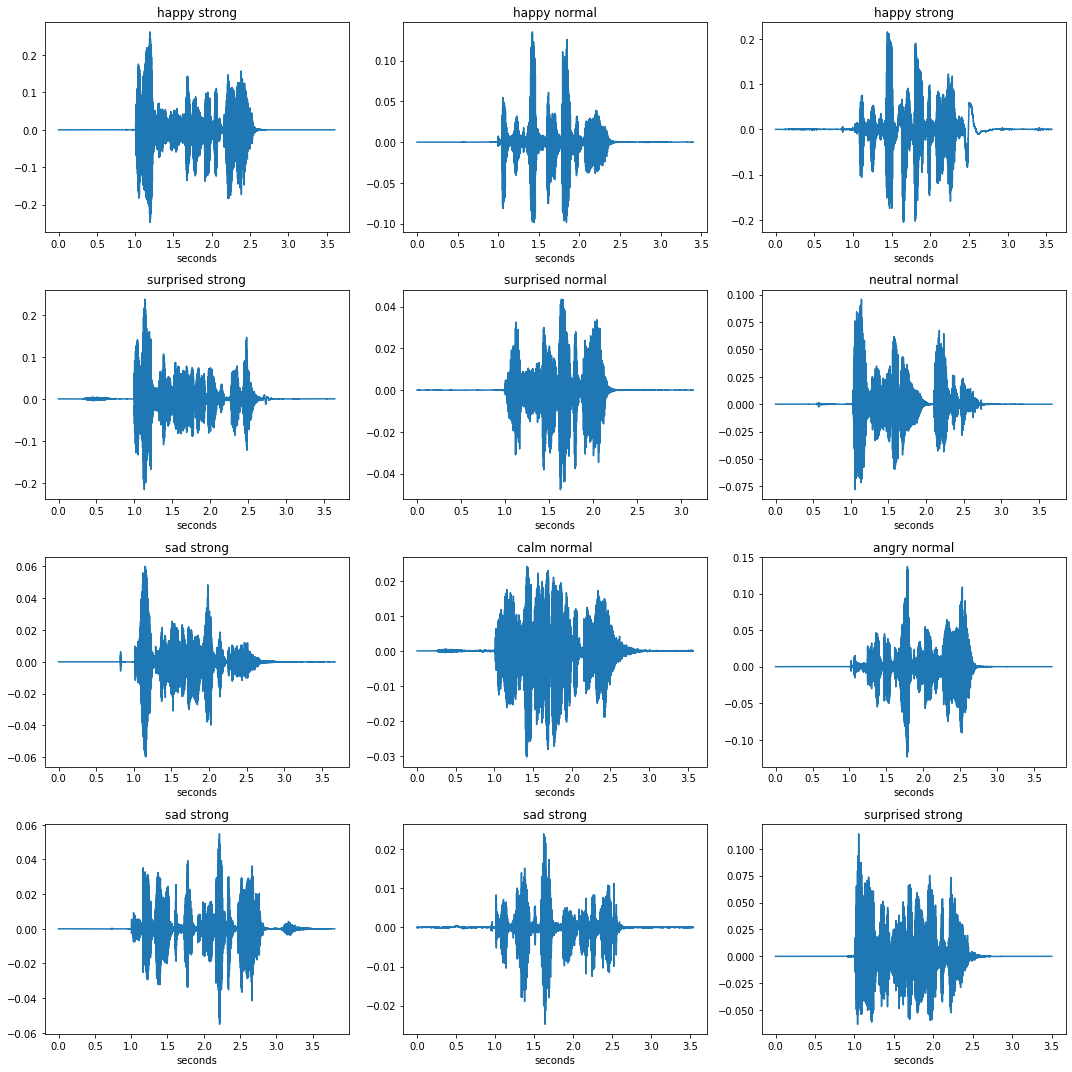

In [23]:
# plotting some random recordings

# emotion names

emotion_names = {0: 'neutral',
                 1: 'calm',
                 2: 'happy',
                 3: 'sad',
                 4: 'angry',
                 5: 'fearful',
                 6: 'disgust',
                 7: 'surprised'}

intensity_names = {0: 'normal',
                   1: 'strong'}


plt.figure(figsize=(15,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    rand = np.random.randint(1440)
    times = np.arange(len(recordings[rand]))/sr
    plt.plot(times, recordings[rand])
    plt.title(emotion_names[labels_emotion[rand]] + ' ' + intensity_names[labels_intensity[rand]] )
    plt.xlabel('seconds')
    plt.tight_layout()

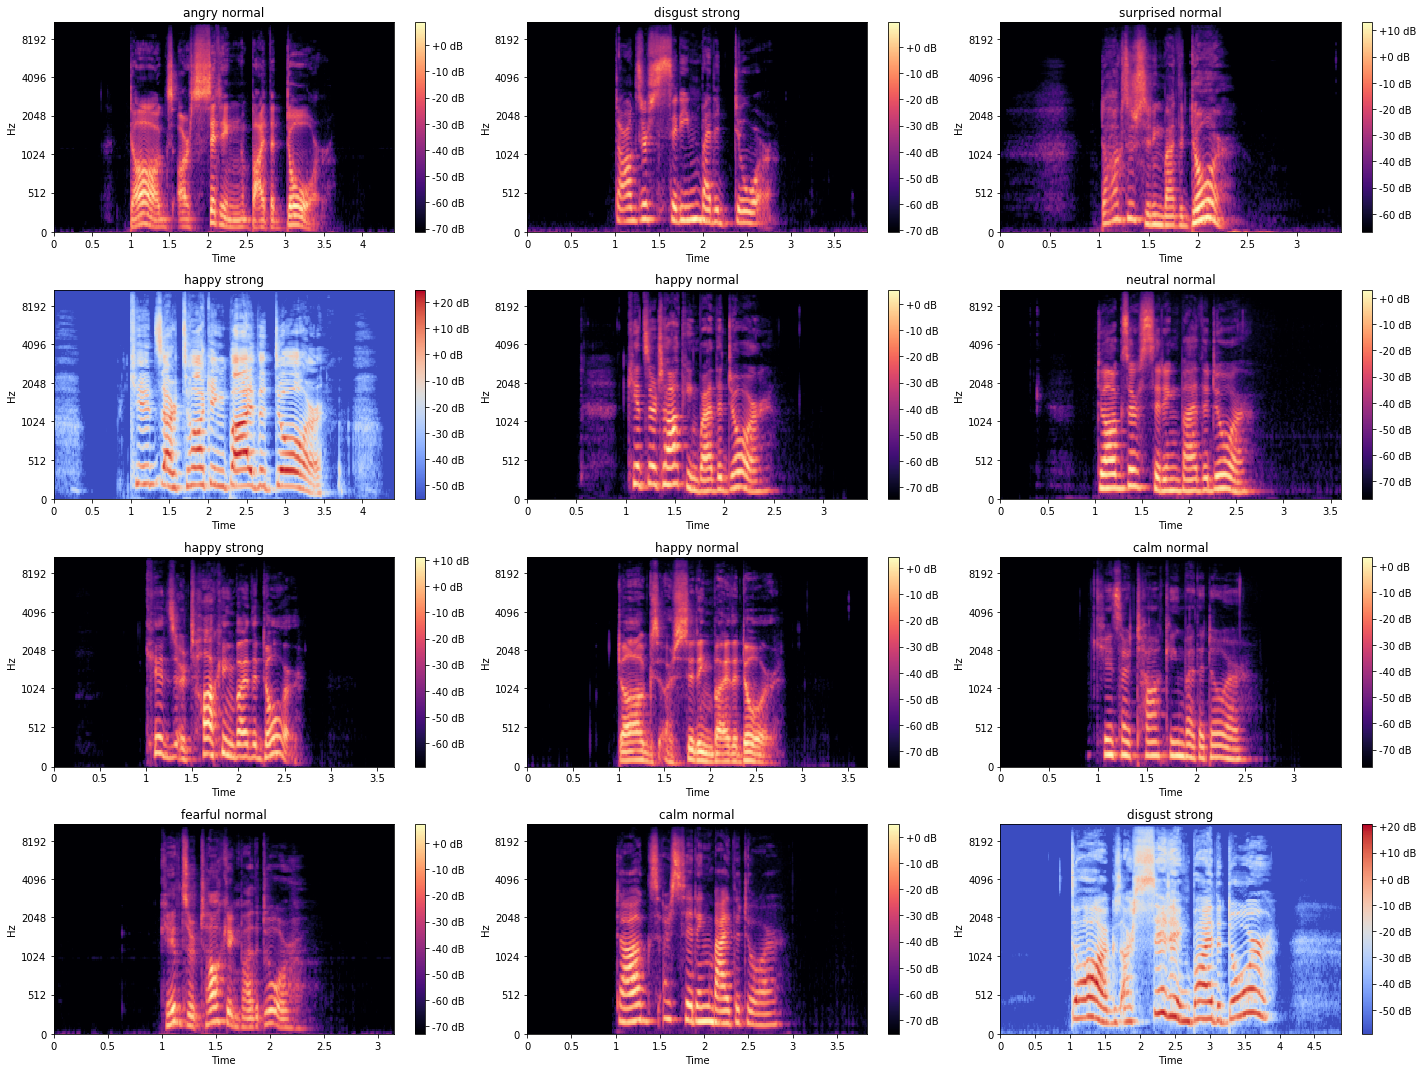

In [17]:
# plotting spectrograms of random recordings
# frequencies are on mel scale here (mel scale is explained below)
# spectrograms show power within frequencies of a signal, with respect to time

from librosa import display

plt.figure(figsize=(20,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    rand = np.random.randint(1440)
    spec = librosa.feature.melspectrogram(recordings[rand], sr=sr)
    spec_db = librosa.power_to_db(spec)
    display.specshow(spec_db, x_axis = 'time', y_axis = 'mel', sr = sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(emotion_names[labels_emotion[rand]] + ' ' + intensity_names[labels_intensity[rand]] )
    plt.tight_layout()

# Modeling

### Creating model inputs - feature extraction

Before creating ML models, we have to extract features from raw sound (wav) files. Wav files contain raw sound waves (amplitudes for each timestep), while number of timesteps per second is determined with sample rate. These raw files do contain all possible information on recorded sound, but in this form they are useless for ML models. So, first, sound features have to be extracted. 

We will do this using Mel Frequency Cepstral Coefficients (MFCC). MFCC is state of the art mathematical model for extracting features from sound waves, which is inspired by way humans hear sounds. Its details can be found here: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/.

In short, it works this way:
 - it cuts soundwave into small windows (for example 2048 samples). These windows overlap (for example, first is from sample 0 to 2048, second is from 1024 to 3096 etc)
 - it takes Discreete Fourier Transform (DFT) of each window, to convert it from time to frequency domain (as seen on above spectograms)
 - then Mel Filterbank is applyed to each window. Here is explanation: - filters are computed based on mel scale (explained below). Each filter puts through only corresponding frequencies, while others are discarded (as shown in image). Then, we compute energy of each filtered part signal. This leaves us with estimated energy for each frequency range, for each window. 
  - **Mel scale:** it is frequency scale, as Hz scale is, but it is not linear, as Hz scale is. It is inspired by the way people hear sounds: we can discriminate lower frequencies much better than higher frequencies (we would for example percieve 400 Hz sound to be much higher than 300 Hz sound, than for 2400 Hz and 2300 Hz). Mel scale makes human perception of sound pitch linear.


  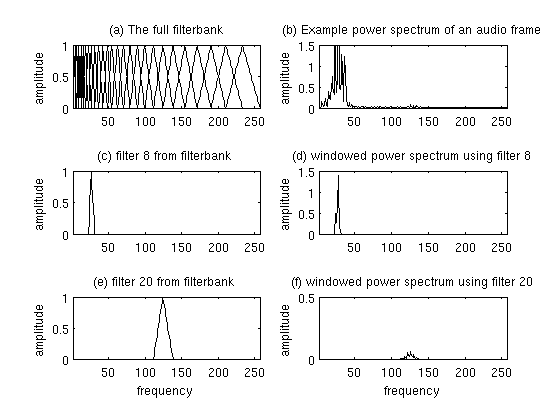
  
- then, log of each computed energy is computed
- finaly, Discrete Cosine Transform is computed of log filterbank energies is taken. This gives us our features, called cepstral coeficients (MFCCs)

Also, deltas and delta deltas are added to features. Deltas are computed from cepstral coefficients. MFCCs give only information about power within certain frequency space, but not about its trajectory. Deltas give us this information. Delta deltas are its second derivaive, like accerelation and speed in physics. Delta deltas are computed in same way, but from deltas instead of MFCCs.

In [11]:
# making inputs for ML models, using MFCC

inputs = []

for i in range(len(recordings)):
    # using 26 filters to get 26 MFCCs
    mfcc = librosa.feature.mfcc(recordings[i], sr = sr, n_mfcc=26)
    delta = librosa.feature.delta(mfcc)
    deltadelta = librosa.feature.delta(mfcc, order=2)
    # transposing, to get timesteps - features shape for ML models
    x = np.hstack((mfcc.T, delta.T, deltadelta.T))
    inputs.append(x)
    
inputs = np.array(inputs)

In [12]:
# we still have 1400 audio samples

inputs.shape

(1440,)

In [13]:
# inputs have different no of timesteps (because they differ in length)
# but each timestep contains 78 features - 26 MFCCs and ther deltas and delta deltas

inputs[1].shape, inputs[442].shape

((354, 78), (357, 78))

In [12]:
# padding with zeros, to ensure equal length of each audio sample

from tensorflow.keras.preprocessing.sequence import pad_sequences
inputs = pad_sequences(inputs)

In [13]:
inputs.shape

(1440, 495, 78)

### Emotional intensity model

In [204]:
# creating NN model_intensity

model_intensity = keras.models.Sequential(name = 'intensity_model_intensity')

model_intensity.add(keras.layers.Input(shape=(495,78,1)))
# using time distributed convolution - convolution is done for features inside each time step, between time steps
model_intensity.add(keras.layers.TimeDistributed(keras.layers.Conv1D(16,3, padding='same', activity_regularizer='l1')))
model_intensity.add(keras.layers.LeakyReLU(0.2))
model_intensity.add(keras.layers.Reshape((495,78*16)))
# masking zeros - following LSTM layer skips inputs timesteps containing all zeros
model_intensity.add(keras.layers.Masking())
model_intensity.add(keras.layers.LSTM(256, activity_regularizer='l1'))
#model_intensity.add(keras.layers.Dropout(0.3))
model_intensity.add(keras.layers.Dense(64, activity_regularizer='l1'))
model_intensity.add(keras.layers.Dropout(0.1))
model_intensity.add(keras.layers.PReLU())
model_intensity.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_intensity.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [207]:
model_intensity.summary()

Model: "intensity_model_intensity"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 495, 78, 16)       64        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 495, 78, 16)       0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 495, 1248)         0         
_________________________________________________________________
masking_13 (Masking)         (None, 495, 1248)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               1541120   
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)  

In [199]:
# train test split
# reshaping it to shape required for time distributed convolution
# time steps - features - channels

X_train, X_test, y_train, y_test = train_test_split(inputs, labels_intensity, random_state = 42, test_size = 0.2)
X_train = X_train.reshape(1152,495,78,1)
X_test = X_test.reshape(288,495,78,1)

In [200]:
# early stopping callback

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.002, patience=20, restore_best_weights=True)

In [201]:
model_intensity.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, 
                    callbacks=[earlystopping])

Train on 1152 samples, validate on 288 samples
Epoch 1/300
1152/1152 [==============================] - 7s 6ms/sample - loss: 30.3644 - accuracy: 0.7127 - val_loss: 26.7469 - val_accuracy: 0.6944
Epoch 2/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 24.5805 - accuracy: 0.7465 - val_loss: 21.4696 - val_accuracy: 0.6771
Epoch 3/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 19.4057 - accuracy: 0.7370 - val_loss: 16.5831 - val_accuracy: 0.7188
Epoch 4/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 14.6685 - accuracy: 0.7422 - val_loss: 12.3684 - val_accuracy: 0.7049
Epoch 5/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 10.8427 - accuracy: 0.7604 - val_loss: 9.0112 - val_accuracy: 0.6910
Epoch 6/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 7.5803 - accuracy: 0.7500 - val_loss: 6.0105 - val_accuracy: 0.7083
Epoch 7/300
1152/1152 [==============================] - 4s 4m

In [208]:
model_intensity.evaluate(X_train, y_train)

1152/1152 [==============================] - 3s 2ms/sample - loss: 0.5889 - accuracy: 0.8212


[0.58888414916065, 0.8211806]

In [209]:
model_intensity.evaluate(X_test, y_test)

288/288 [==============================] - 1s 2ms/sample - loss: 0.6169 - accuracy: 0.7778


[0.6169190009435018, 0.7777778]

In [71]:
preds_train = model_intensity.predict_classes(X_train)
preds_test = model_intensity.predict_classes(X_test)

([<matplotlib.axis.YTick at 0x7fe161e08ad0>,
 <a list of 2 Text yticklabel objects>)

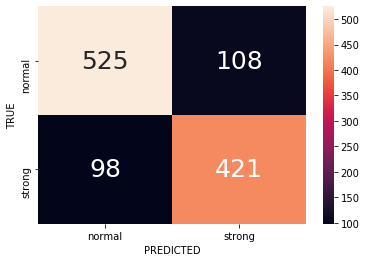

In [77]:
# train cm

sns.heatmap(confusion_matrix(y_train, preds_train), annot=True, fmt='g', annot_kws={'size':25})
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5],['normal', 'strong'])
plt.yticks([0.5,1.5],['normal', 'strong'])

([<matplotlib.axis.YTick at 0x7fe15ed82410>,
 <a list of 2 Text yticklabel objects>)

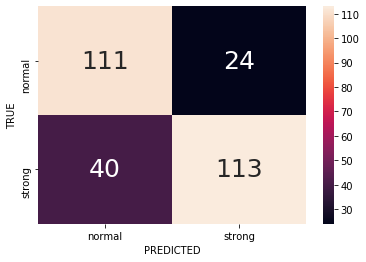

In [78]:
# test cm

sns.heatmap(confusion_matrix(y_test, preds_test), annot=True, fmt='g', annot_kws={'size':25})
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5],['normal', 'strong'])
plt.yticks([0.5,1.5],['normal', 'strong'])

In [74]:
# precision, recall, f1

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('train accuracy: ', accuracy_score(y_train, preds_train), 
      '   test accuracy: ', accuracy_score(y_test, preds_test))
print('train precision: ', precision_score(y_train, preds_train), 
      '   test precision: ', precision_score(y_test, preds_test))
print('train recall: ', recall_score(y_train, preds_train), 
      '   test recall: ', recall_score(y_test, preds_test))
print('train f1: ', f1_score(y_train, preds_train), 
      '   test f1: ', f1_score(y_test, preds_test))

train accuracy:  0.8211805555555556    test accuracy:  0.7777777777777778
train precision:  0.7958412098298677    test precision:  0.8248175182481752
train recall:  0.8111753371868978    test recall:  0.738562091503268
train f1:  0.8034351145038168    test f1:  0.7793103448275862


In [79]:
# saving model

os.chdir('/home/ksaver/Desktop/faks/afektivno racunarstvo/projekt')
model_intensity.save('model_intensity.h5')

#### Comments

It turns out model works fine, although its scores are not very impressive. Nonetheless, it manages to discriminate high and normal intensity emotionality with 78% accuracy. Its precision and recall scores are more or less balanced, i.e. it missclassifies strong emotional states as normal and vice versa with similar frequency. Model overfits a bit. Some of overfitting is prevented with regularization and dropout, however not all of it. Adding more dropout or regularization would make model unstable.

Based on this, computer could recognize person's emotional intensity based on his/hers voice with reasonable accuracy.

There is some room for improvement, but our tweaking of NN hyperparameters, such as adding more convolutional, LSTM or dense layers, bidirectional LSTMs, adding and removing dropout, batch normalization, regularization etc could not lead to any better results, but would often lead to model failing completely or taking significantly longer to train.


### Emotion recognizing model

We have tried creating separate models for strong and normal intensity emotions, as well as single model for both strong and normal intensity. It turns out single model performs better, likely because more data is available.

This model discriminates between voice recordings of various emotions.

In [172]:
# creating NN model_emotion

model_emotion = keras.models.Sequential(name = 'emotion_model')

model_emotion.add(keras.layers.Input(shape=(495,78,1)))
# using time distributed convolution - convolution is done for features inside each time step, between time steps
model_emotion.add(keras.layers.TimeDistributed(keras.layers.Conv1D(16,5, padding='same', activity_regularizer='l1')))
#model_emotion.add(keras.layers.Dropout(0.2))
model_emotion.add(keras.layers.LeakyReLU(0.2))
model_emotion.add(keras.layers.Reshape((495,78*16)))
# masking zeros - following LSTM layer skips inputs timesteps containing all zeros
model_emotion.add(keras.layers.Masking())
model_emotion.add(keras.layers.LSTM(256, activity_regularizer='l1'))
#model_emotion.add(keras.layers.Dropout(0.3))
model_emotion.add(keras.layers.Dense(64, activity_regularizer='l1'))
model_emotion.add(keras.layers.Dropout(0.2))
model_emotion.add(keras.layers.LeakyReLU(0.2))
model_emotion.add(keras.layers.Dense(8, activation = 'softmax'))

model_emotion.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [173]:
model_emotion.summary()

Model: "emotion_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 495, 78, 16)       96        
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 495, 78, 16)       0         
_________________________________________________________________
reshape_27 (Reshape)         (None, 495, 1248)         0         
_________________________________________________________________
masking_27 (Masking)         (None, 495, 1248)         0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 256)               1541120   
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)              

In [174]:
# early stopping callback

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.002, patience=20, restore_best_weights=True)

In [168]:
# train test split
# reshaping it to shape required for time distributed convolution
# time steps - features - channels

X_train, X_test, y_train, y_test = train_test_split(inputs, labels_emotion, random_state = 42, test_size = 0.2)
X_train = X_train.reshape(1152,495,78,1)
X_test = X_test.reshape(288,495,78,1)

In [175]:
model_emotion.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, 
                    callbacks=[earlystopping])

Train on 1152 samples, validate on 288 samples
Epoch 1/300
1152/1152 [==============================] - 7s 6ms/sample - loss: 36.7897 - accuracy: 0.2040 - val_loss: 31.6019 - val_accuracy: 0.2569
Epoch 2/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 28.3868 - accuracy: 0.2648 - val_loss: 23.9875 - val_accuracy: 0.2708
Epoch 3/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 20.9985 - accuracy: 0.2865 - val_loss: 17.2854 - val_accuracy: 0.2917
Epoch 4/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 14.5772 - accuracy: 0.3168 - val_loss: 11.4148 - val_accuracy: 0.2604
Epoch 5/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 9.0947 - accuracy: 0.3220 - val_loss: 6.6242 - val_accuracy: 0.2743
Epoch 6/300
1152/1152 [==============================] - 4s 4ms/sample - loss: 4.9333 - accuracy: 0.3090 - val_loss: 3.6022 - val_accuracy: 0.2569
Epoch 7/300
1152/1152 [==============================] - 4s 4ms

In [176]:
model_emotion.evaluate(X_train, y_train)

1152/1152 [==============================] - 2s 1ms/sample - loss: 0.3631 - accuracy: 0.9991


[0.36313329968187547, 0.9991319]

In [177]:
model_emotion.evaluate(X_test, y_test)

288/288 [==============================] - 0s 1ms/sample - loss: 1.0394 - accuracy: 0.7917


[1.0394475526279874, 0.7916667]

In [178]:
preds_train = model_emotion.predict_classes(X_train)
preds_test = model_emotion.predict_classes(X_test)

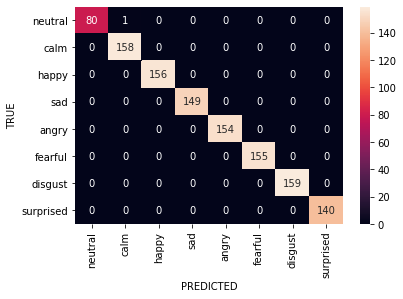

In [179]:
# train cm

sns.heatmap(confusion_matrix(y_train, preds_train), annot=True, fmt='g', annot_kws={'size':10})
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],
           ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
          rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],
           ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
          rotation = 0)
plt.show()

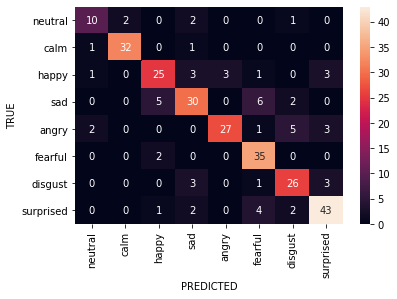

In [180]:
# test cm

sns.heatmap(confusion_matrix(y_test, preds_test), annot=True, fmt='g', annot_kws={'size':10})
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],
           ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
          rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],
           ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
          rotation = 0)
plt.show()

In [195]:
# train scores

from sklearn.metrics import precision_recall_fscore_support as prf

scores = prf(y_train, preds_train)

df = pd.DataFrame(np.empty((8,4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores[0])):
    df.iloc[i,:] = [x[i] for x in scores]
df.index = list(emotion_names.values())
df

,precision,recall,f1,support
neutral,1.000000,0.987654,0.993789,81.0
calm,0.993711,1.000000,0.996845,158.0
happy,1.000000,1.000000,1.000000,156.0
sad,1.000000,1.000000,1.000000,149.0
angry,1.000000,1.000000,1.000000,154.0
fearful,1.000000,1.000000,1.000000,155.0
disgust,1.000000,1.000000,1.000000,159.0
surprised,1.000000,1.000000,1.000000,140.0


In [196]:
# test scores

scores = prf(y_test, preds_test)

df = pd.DataFrame(np.empty((8,4)), columns=['precision','recall','f1','support'])
for i in range(0,len(scores[0])):
    df.iloc[i,:] = [x[i] for x in scores]
df.index = list(emotion_names.values())
df

,precision,recall,f1,support
neutral,0.714286,0.666667,0.689655,15.0
calm,0.941176,0.941176,0.941176,34.0
happy,0.757576,0.694444,0.724638,36.0
sad,0.731707,0.697674,0.714286,43.0
angry,0.900000,0.710526,0.794118,38.0
fearful,0.729167,0.945946,0.823529,37.0
disgust,0.722222,0.787879,0.753623,33.0
surprised,0.826923,0.826923,0.826923,52.0


In [181]:
# saving model

os.chdir('/home/ksaver/Desktop/faks/afektivno racunarstvo/projekt')
model_emotion.save('model_emotion.h5')

### Comments

As we can see, model overfits a lot. However, it still manages to generalize to validation data with 79% accuracy, and all f1 scores over 0.7. So results are not that bad. Models with added regularization and dropout to avoid overfitting would fail here. So, without overfitting it was impossible to develop model with this high accuracy on validation data.

To sum up, given models are able to recognize human emotion and its intensity with reasonable accuracy.